# Modelo Preditivo - Tempo de Entrega (ETA)
Notebook para criar modelo preditivo que melhore a estimativa de tempo de entrega.

**Objetivo:** Melhorar a precisão da estimativa de tempo de entrega (`eta_minutes_quote`) apenas para pedidos dos canais próprios (site_proprio + whatsapp).

**Metodologia:** Divisão train/test dupla, cross-validation e comparação de 5 modelos usando RMSE.


## 1. Setup e Imports


In [549]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Configurações visuais
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 10

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


## 2. Carregamento dos Dados


In [550]:
# Carregar dados limpos
df = pd.read_csv("../tratamento_inicial/Base_Kaiserhaus_Limpa.csv")

print("Dados carregados:")
print(f"   • Total de registros: {len(df):,}")
print(f"   • Colunas: {df.shape[1]}")
print(f"   • Valores nulos: {df.isnull().sum().sum()}")

print("\nColunas disponíveis:")
print(list(df.columns))


Dados carregados:
   • Total de registros: 5,000
   • Colunas: 16
   • Valores nulos: 0

Colunas disponíveis:
['macro_bairro', 'nome_cliente', 'bairro_destino', 'order_datetime', 'platform', 'order_mode', 'distance_km', 'tempo_preparo_minutos', 'status', 'eta_minutes_quote', 'actual_delivery_minutes', 'total_brl', 'classe_pedido', 'platform_commission_pct', 'num_itens', 'satisfacao_nivel']


## 3. Filtro para Canais Próprios


In [551]:
# Filtrar apenas canais próprios
df_canais_proprios = df.copy()



## 4. Feature Engineering e One-Hot Encoding


In [552]:
df['order_datetime'] = pd.to_datetime(df['order_datetime'])

df['hora_pedido'] = df['order_datetime'].dt.hour
df['dia_semana'] = df['order_datetime'].dt.day_name()
df['is_weekend'] = df['order_datetime'].dt.weekday >= 5

# Criar período do dia baseado nos insights (horários críticos identificados)
def categorizar_periodo_dia(hora):
    if 6 <= hora < 12:
        return 'Manhã'
    elif 12 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora < 24:
        return 'Noite'
    else:
        return 'Madrugada'

df['periodo_dia'] = df['hora_pedido'].apply(categorizar_periodo_dia)

# aqui seriia a criacao de features baseadas nos insights

# sazonalidade diária
df['hora_sin'] = np.sin(2 * np.pi * df['hora_pedido'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['hora_pedido'] / 24)

# flags para cenários críticos identificados na análise
df['is_horario_critico'] = df['hora_pedido'].isin([18, 19, 20, 21, 22, 23]).astype(int)
df['is_plataforma_critica'] = (df['platform'] == 'ifood').astype(int)
df['is_bairro_critico'] = df['macro_bairro'].isin(['Morumbi', 'Vila Mariana', 'Santo Amaro']).astype(int)


CORRELAÇÃO ENTRE VARIÁVEIS


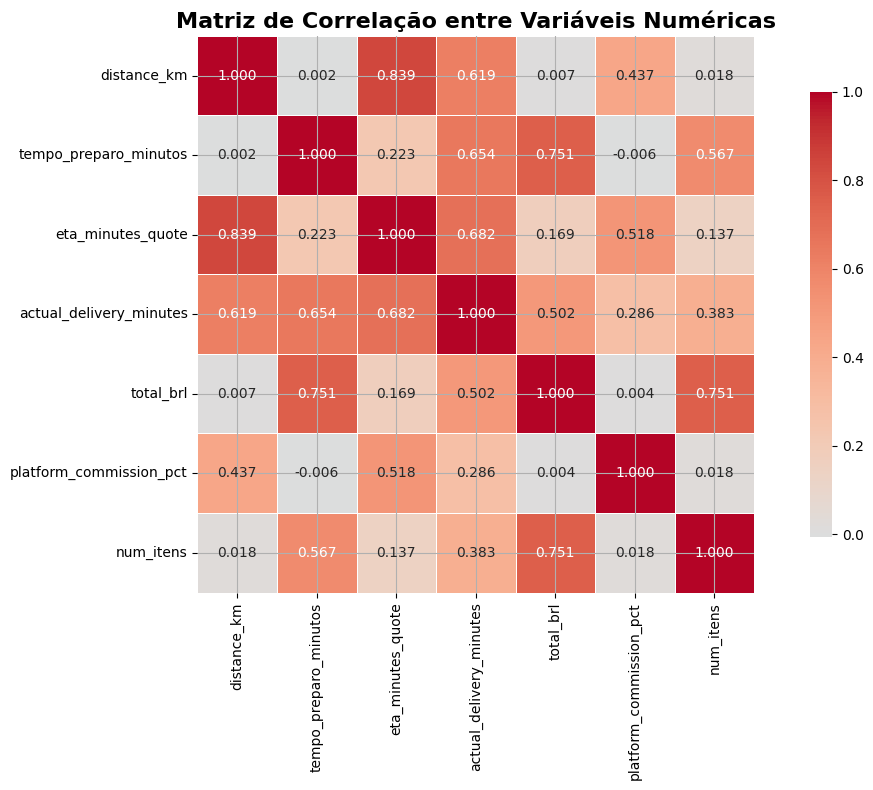

In [553]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar a base limpa
df = pd.read_csv('../tratamento_inicial/Base_Kaiserhaus_Limpa.csv')

print("CORRELAÇÃO ENTRE VARIÁVEIS")
print("=" * 60)

# Selecionar variáveis numéricas para correlação
variaveis_numericas = ['distance_km', 'tempo_preparo_minutos', 'eta_minutes_quote', 
                       'actual_delivery_minutes', 'total_brl', 'platform_commission_pct', 
                       'num_itens']

# Criar matriz de correlação
correlacao = df[variaveis_numericas].corr()


# Visualizar heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlação entre Variáveis Numéricas', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [554]:
# Função para obter período do dia
def obter_periodo_dia(hora):
    if 0 <= hora < 6:
        return 'Madrugada'
    elif 6 <= hora < 12:
        return 'Manhã'
    elif 12 <= hora < 18:
        return 'Tarde'
    else:
        return 'Noite'
    
def obter_dia_semana(data):
    return pd.to_datetime(data).dt.day_name()

# Criar dia da semana no DataFrame
df_canais_proprios['dia_semana'] = obter_dia_semana(df_canais_proprios['order_datetime'])

# Criar período do dia diretamente no DataFrame
df_canais_proprios['periodo_dia'] = pd.to_datetime(df_canais_proprios['order_datetime']).dt.hour.apply(obter_periodo_dia)

# Selecionar features
features_numericas = ['distance_km', 'tempo_preparo_minutos', 'num_itens', 'total_brl']
features_categoricas = ['periodo_dia', 'platform', 'dia_semana']
target = 'actual_delivery_minutes'

# Criar DataFrames separados
X_numericas = df_canais_proprios[features_numericas].copy()
X_categoricas = df_canais_proprios[features_categoricas].copy()
y = df_canais_proprios[target].copy()

# Aplicar One-Hot Encoding nas colunas categóricas SEM remover nenhuma categoria
encoder = OneHotEncoder(sparse_output=False, drop=None)
X_categoricas_encoded = encoder.fit_transform(X_categoricas)

# Criar DataFrame com nomes das colunas
feature_names = encoder.get_feature_names_out(features_categoricas)
X_categoricas_df = pd.DataFrame(X_categoricas_encoded, columns=feature_names, index=X_categoricas.index)

# Combinar features numéricas e categóricas
X_intermediario = pd.concat([X_numericas, X_categoricas_df], axis=1)

# features adicionais baseadas nos insights
X_insights = df[['hora_sin', 'hora_cos', 
                 'is_horario_critico', 'is_plataforma_critica', 'is_bairro_critico']].copy()

#comobinar as features X
X_final = pd.concat([X_intermediario, X_insights], axis=1)

# Salvar base com One-Hot Encoding aplicado
df_base_final = pd.concat([df_canais_proprios[features_numericas + ['actual_delivery_minutes']], X_categoricas_df], axis=1)
df_base_final.to_csv("base_modelo_preditivo_eta.csv", index=False)

print("FEATURE ENGINEERING COMPLETO")
print("=" * 50)
print("Arquivo: 'base_modelo_preditivo_eta.csv'")
print(f"Total de registros: {len(df_base_final):,}")
print(f"Colunas: {df_base_final.shape[1]}")
print(f"Features categóricas criadas: {len(feature_names)}")

print("\nDistribuição por período do dia:")
distribuicao_periodo = df_canais_proprios['periodo_dia'].value_counts()
for periodo, count in distribuicao_periodo.items():
    pct = count / len(df_canais_proprios) * 100
    print(f"   • {periodo}: {count:,} pedidos ({pct:.1f}%)")



KeyError: "None of [Index(['hora_sin', 'hora_cos', 'is_horario_critico', 'is_plataforma_critica',\n       'is_bairro_critico'],\n      dtype='object')] are in the [columns]"

## 5. Divisão Train/Test Dupla e Modelos


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# 1️⃣ Split único (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, shuffle=True
)

# 2️⃣ Split Duplo (80/20) - Validação interna
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

# 3️⃣ Definir modelos
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

modelos = {
    # Dummy Regressor - variações
    'Dummy Regressor (Mean)': DummyRegressor(strategy='mean'),
    
    # Linear Regression - variações
    'Linear Regression (Pipeline)': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]),
    
    # Decision Tree - variações
    'Decision Tree (Default)': DecisionTreeRegressor(random_state=42),
    'Decision Tree (10)': DecisionTreeRegressor(
        max_depth=10, 
        min_samples_split=20, 
        min_samples_leaf=10, 
        random_state=42
    ),
    'Decision Tree (15)': DecisionTreeRegressor(
        max_depth=15, 
        min_samples_split=5, 
        min_samples_leaf=2, 
        random_state=42
    ),
    
    # Random Forest - variações
    'Random Forest (100)': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    ),
    'Random Forest (200)': RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    ),
    'Random Forest (500)': RandomForestRegressor(
        n_estimators=500,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    ),
}

# 4️⃣ TESTAR TODOS OS MODELOS NO SPLIT PRINCIPAL
print("TESTE INICIAL - TODOS OS MODELOS")
print("=" * 55)

resultados_iniciais = {}

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    
    # Previsões
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    
    # Cálculo de RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    resultados_iniciais[nome] = {
        'RMSE Treino': rmse_train,
        'RMSE Teste': rmse_test,
    }
    
    print(f"{nome:25s} → RMSE Treino = {rmse_train:.3f} | RMSE Teste = {rmse_test:.3f}")

TESTE INICIAL - TODOS OS MODELOS
Dummy Regressor (Mean)    → RMSE Treino = 12.632 | RMSE Teste = 12.739
Linear Regression (Pipeline) → RMSE Treino = 5.493 | RMSE Teste = 5.544
Decision Tree (Default)   → RMSE Treino = 0.000 | RMSE Teste = 8.014
Decision Tree (10)        → RMSE Treino = 4.884 | RMSE Teste = 6.225
Decision Tree (15)        → RMSE Treino = 2.730 | RMSE Teste = 7.458
Random Forest (100)       → RMSE Treino = 4.300 | RMSE Teste = 5.786
Random Forest (200)       → RMSE Treino = 4.289 | RMSE Teste = 5.769
Random Forest (500)       → RMSE Treino = 4.287 | RMSE Teste = 5.765


## 6. Validação

In [ ]:
# 5️⃣ ESCOLHER O MELHOR MODELO
melhor_modelo_nome = ('Random Forest (100)')
# 6️⃣ TESTAR APENAS O MELHOR MODELO NO SPLIT DUPLO
print(f"\nVALIDAÇÃO FINAL - APENAS {melhor_modelo_nome}")
print("=" * 60)

# Obter o modelo escolhido
melhor_modelo = modelos[melhor_modelo_nome]

# Teste no split duplo
melhor_modelo.fit(X_train_2, y_train_2)
y_pred_train_2 = melhor_modelo.predict(X_train_2)
y_pred_test_2 = melhor_modelo.predict(X_test_2)

# RMSE no split duplo
rmse_train_2 = np.sqrt(mean_squared_error(y_train_2, y_pred_train_2))
rmse_test_2 = np.sqrt(mean_squared_error(y_test_2, y_pred_test_2))

print(f"RMSE Treino (Split 2): {rmse_train_2:.3f}")
print(f"RMSE Teste (Split 2): {rmse_test_2:.3f}")

# 7️⃣ COMPARAÇÃO FINAL
print(f"\nCOMPARAÇÃO FINAL:")
print("=" * 40)
print(f"RMSE Teste (Split 1): {resultados_iniciais[melhor_modelo_nome]['RMSE Teste']:.3f}")
print(f"RMSE Teste (Split 2): {rmse_test_2:.3f}")

# Verificar consistência
diferenca = abs(resultados_iniciais[melhor_modelo_nome]['RMSE Teste'] - rmse_test_2)
print(f"Diferença: {diferenca:.3f}")



VALIDAÇÃO FINAL - APENAS Random Forest (100)
RMSE Treino (Split 2): 4.335
RMSE Teste (Split 2): 5.364

COMPARAÇÃO FINAL:
RMSE Teste (Split 1): 5.786
RMSE Teste (Split 2): 5.364
Diferença: 0.422


## 7. Comparacao com ETA antigo

In [ ]:
# COMPARAÇÃO ETA ANTIGO vs NOVO vs ACTUAL
print(" COMPARAÇÃO ETA ANTIGO vs NOVO vs ACTUAL")
print("=" * 60)

# Usar o melhor modelo (Random Forest 500)
melhor_modelo = modelos['Random Forest (100)']
melhor_modelo.fit(X_final, y)

# Fazer predições
eta_novo = melhor_modelo.predict(X_final)

# Criar DataFrame de comparação
comparacao = pd.DataFrame({
    'Pedido': range(1, len(df_canais_proprios) + 1),
    'ETA_Antigo': df_canais_proprios['eta_minutes_quote'].values,
    'ETA_Novo': eta_novo,
    'Actual_Delivery': df_canais_proprios['actual_delivery_minutes'].values
})

# Calcular diferenças
comparacao['Diff_Antigo'] = comparacao['Actual_Delivery'] - comparacao['ETA_Antigo']
comparacao['Diff_Novo'] = comparacao['Actual_Delivery'] - comparacao['ETA_Novo']

# Calcular erros absolutos
comparacao['Erro_Abs_Antigo'] = abs(comparacao['Diff_Antigo'])
comparacao['Erro_Abs_Novo'] = abs(comparacao['Diff_Novo'])

# Estatísticas gerais
print(f"\n ESTATÍSTICAS GERAIS:")
print(f"   • RMSE ETA Antigo: {np.sqrt(mean_squared_error(comparacao['Actual_Delivery'], comparacao['ETA_Antigo'])):.3f}")
print(f"   • RMSE ETA Novo: {np.sqrt(mean_squared_error(comparacao['Actual_Delivery'], comparacao['ETA_Novo'])):.3f}")
print(f"   • Melhoria: {((np.sqrt(mean_squared_error(comparacao['Actual_Delivery'], comparacao['ETA_Antigo'])) - np.sqrt(mean_squared_error(comparacao['Actual_Delivery'], comparacao['ETA_Novo']))) / np.sqrt(mean_squared_error(comparacao['Actual_Delivery'], comparacao['ETA_Antigo'])) * 100):.1f}%")

# Mostrar alguns exemplos de melhoria
print(f"\n EXEMPLOS DE MELHORIA:")
melhorias = comparacao[comparacao['Erro_Abs_Novo'] < comparacao['Erro_Abs_Antigo']].head(10)
print(f"{'Pedido':<8} {'ETA Antigo':<12} {'ETA Novo':<12} {'Actual':<12} {'Erro Antigo':<12} {'Erro Novo':<12}")
print("-" * 80)
for _, row in melhorias.iterrows():
    print(f"{row['Pedido']:<8} {row['ETA_Antigo']:<12.1f} {row['ETA_Novo']:<12.1f} {row['Actual_Delivery']:<12.1f} {row['Erro_Abs_Antigo']:<12.1f} {row['Erro_Abs_Novo']:<12.1f}")

# Mostrar alguns exemplos de piora
print(f"\n EXEMPLOS DE PIORA:")
pioras = comparacao[comparacao['Erro_Abs_Novo'] > comparacao['Erro_Abs_Antigo']].head(10)
print(f"{'Pedido':<8} {'ETA Antigo':<12} {'ETA Novo':<12} {'Actual':<12} {'Erro Antigo':<12} {'Erro Novo':<12}")
print("-" * 80)
for _, row in pioras.iterrows():
    print(f"{row['Pedido']:<8} {row['ETA_Antigo']:<12.1f} {row['ETA_Novo']:<12.1f} {row['Actual_Delivery']:<12.1f} {row['Erro_Abs_Antigo']:<12.1f} {row['Erro_Abs_Novo']:<12.1f}")

# Contar melhorias vs pioras
melhorias_count = len(comparacao[comparacao['Erro_Abs_Novo'] < comparacao['Erro_Abs_Antigo']])
pioras_count = len(comparacao[comparacao['Erro_Abs_Novo'] > comparacao['Erro_Abs_Antigo']])
iguais_count = len(comparacao[comparacao['Erro_Abs_Novo'] == comparacao['Erro_Abs_Antigo']])

print(f"\n RESUMO:")
print(f"   • Pedidos com melhoria: {melhorias_count} ({melhorias_count/len(comparacao)*100:.1f}%)")
print(f"   • Pedidos com piora: {pioras_count} ({pioras_count/len(comparacao)*100:.1f}%)")
print(f"   • Pedidos iguais: {iguais_count} ({iguais_count/len(comparacao)*100:.1f}%)")

 COMPARAÇÃO ETA ANTIGO vs NOVO vs ACTUAL

 ESTATÍSTICAS GERAIS:
   • RMSE ETA Antigo: 12.179
   • RMSE ETA Novo: 4.372
   • Melhoria: 64.1%

 EXEMPLOS DE MELHORIA:
Pedido   ETA Antigo   ETA Novo     Actual       Erro Antigo  Erro Novo   
--------------------------------------------------------------------------------
1.0      50.0         64.1         62.4         12.4         1.7         
2.0      45.0         36.3         35.6         9.4          0.7         
3.0      43.0         32.0         34.5         8.5          2.5         
4.0      19.0         10.6         14.4         4.6          3.8         
6.0      44.0         34.4         33.5         10.5         0.9         
7.0      44.0         29.9         36.5         7.5          6.6         
8.0      40.0         31.7         34.5         5.5          2.8         
9.0      29.0         22.2         19.9         9.1          2.3         
11.0     29.0         12.7         7.2          21.8         5.5         
12.0     47.0  

In [ ]:
# ANÁLISE DETALHADA DAS PIORAS
print("ANÁLISE DETALHADA DAS PIORAS")
print("=" * 60)

# Separar categorias
melhorias = comparacao[comparacao['Erro_Abs_Novo'] < comparacao['Erro_Abs_Antigo']]
pioras = comparacao[comparacao['Erro_Abs_Novo'] > comparacao['Erro_Abs_Antigo']]
iguais = comparacao[comparacao['Erro_Abs_Novo'] == comparacao['Erro_Abs_Antigo']]

# Estatísticas das melhorias
print(f"\nMELHORIAS ({len(melhorias)} pedidos):")
print(f"   • Erro Antigo - Média: {melhorias['Erro_Abs_Antigo'].mean():.3f} | Std: {melhorias['Erro_Abs_Antigo'].std():.3f}")
print(f"   • Erro Novo - Média: {melhorias['Erro_Abs_Novo'].mean():.3f} | Std: {melhorias['Erro_Abs_Novo'].std():.3f}")
print(f"   • Redução média: {melhorias['Erro_Abs_Antigo'].mean() - melhorias['Erro_Abs_Novo'].mean():.3f} min")

# Estatísticas das pioras
print(f"\nPIORAS ({len(pioras)} pedidos):")
print(f"   • Erro Antigo - Média: {pioras['Erro_Abs_Antigo'].mean():.3f} | Std: {pioras['Erro_Abs_Antigo'].std():.3f}")
print(f"   • Erro Novo - Média: {pioras['Erro_Abs_Novo'].mean():.3f} | Std: {pioras['Erro_Abs_Novo'].std():.3f}")
print(f"   • Aumento médio: {pioras['Erro_Abs_Novo'].mean() - pioras['Erro_Abs_Antigo'].mean():.3f} min")


ANÁLISE DETALHADA DAS PIORAS

MELHORIAS (4135 pedidos):
   • Erro Antigo - Média: 11.752 | Std: 6.164
   • Erro Novo - Média: 2.917 | Std: 2.358
   • Redução média: 8.836 min

PIORAS (865 pedidos):
   • Erro Antigo - Média: 2.879 | Std: 2.693
   • Erro Novo - Média: 5.579 | Std: 3.484
   • Aumento médio: 2.701 min


In [ ]:
# ANÁLISE DE PADRÕES DAS PIORAS COM PERCENTUAL DE PIORAS POR FAIXA
print("ANÁLISE DE PADRÕES DAS PIORAS COM PERCENTUAL DE PIORAS POR FAIXA")
print("=" * 70)

# Separar pioras
pioras = comparacao[comparacao['Erro_Abs_Novo'] > comparacao['Erro_Abs_Antigo']]

print(f"Total de pioras: {len(pioras)} pedidos")
print(f"Percentual geral: {len(pioras)/len(comparacao)*100:.1f}%")

# Adicionar informações da plataforma às pioras
pioras_com_info = pioras.copy()
pioras_com_info['platform'] = df_canais_proprios.loc[pioras.index, 'platform'].values
pioras_com_info['periodo_dia'] = df_canais_proprios.loc[pioras.index, 'periodo_dia'].values
pioras_com_info['distance_km'] = df_canais_proprios.loc[pioras.index, 'distance_km'].values
pioras_com_info['tempo_preparo_minutos'] = df_canais_proprios.loc[pioras.index, 'tempo_preparo_minutos'].values
pioras_com_info['num_itens'] = df_canais_proprios.loc[pioras.index, 'num_itens'].values

#ANÁLISE POR PLATAFORMA
print(f"\nANÁLISE POR PLATAFORMA:")
print("=" * 50)

# Contar total por plataforma na base inteira
total_por_platform = df_canais_proprios['platform'].value_counts()
total_geral = len(df_canais_proprios)

# Análise por plataforma
platform_analysis = pioras_com_info.groupby('platform').agg({
    'Erro_Abs_Antigo': ['count', 'mean', 'std'],
    'Erro_Abs_Novo': ['mean', 'std'],
    'distance_km': 'mean',
    'tempo_preparo_minutos': 'mean',
    'num_itens': 'mean'
}).round(3)

platform_analysis.columns = ['Qtd_Pioras', 'Erro_Antigo_Medio', 'Erro_Antigo_Std', 
                            'Erro_Novo_Medio', 'Erro_Novo_Std', 'Distancia_Media', 
                            'Tempo_Preparo_Medio', 'Num_Itens_Medio']

# Adicionar percentuais da base inteira
platform_analysis['Total_Base'] = platform_analysis.index.map(total_por_platform)
platform_analysis['Pct_Pioras_Da_Faixa'] = (platform_analysis['Qtd_Pioras'] / platform_analysis['Total_Base'] * 100).round(1)

print(f"{'Plataforma':<15} {'Qtd':<6} {'Total':<8} {'% Pioras':<10} {'Erro Antigo':<12} {'Erro Novo':<12} {'Distância':<10} {'Preparo':<8} {'Itens':<6}")
print("-" * 100)
for platform, row in platform_analysis.iterrows():
    print(f"{platform:<15} {row['Qtd_Pioras']:<6} {row['Total_Base']:<8} {row['Pct_Pioras_Da_Faixa']:<10} {row['Erro_Antigo_Medio']:<12.3f} {row['Erro_Novo_Medio']:<12.3f} {row['Distancia_Media']:<10.2f} {row['Tempo_Preparo_Medio']:<8.1f} {row['Num_Itens_Medio']:<6.1f}")

#ANÁLISE POR PERÍODO DO DIA
print(f"\nANÁLISE POR PERÍODO DO DIA:")
print("=" * 50)

# Contar total por período na base inteira
total_por_periodo = df_canais_proprios['periodo_dia'].value_counts()

periodo_analysis = pioras_com_info.groupby('periodo_dia').agg({
    'Erro_Abs_Antigo': ['count', 'mean'],
    'Erro_Abs_Novo': 'mean',
    'distance_km': 'mean',
    'tempo_preparo_minutos': 'mean'
}).round(3)

periodo_analysis.columns = ['Qtd_Pioras', 'Erro_Antigo_Medio', 'Erro_Novo_Medio', 
                           'Distancia_Media', 'Tempo_Preparo_Medio']

# Adicionar percentuais da base inteira
periodo_analysis['Total_Base'] = periodo_analysis.index.map(total_por_periodo)
periodo_analysis['Pct_Pioras_Da_Faixa'] = (periodo_analysis['Qtd_Pioras'] / periodo_analysis['Total_Base'] * 100).round(1)

print(f"{'Período':<12} {'Qtd':<6} {'Total':<8} {'% Pioras':<10} {'Erro Antigo':<12} {'Erro Novo':<12} {'Distância':<10} {'Preparo':<8}")
print("-" * 90)
for periodo, row in periodo_analysis.iterrows():
    print(f"{periodo:<12} {row['Qtd_Pioras']:<6} {row['Total_Base']:<8} {row['Pct_Pioras_Da_Faixa']:<10} {row['Erro_Antigo_Medio']:<12.3f} {row['Erro_Novo_Medio']:<12.3f} {row['Distancia_Media']:<10.2f} {row['Tempo_Preparo_Medio']:<8.1f}")


#ANÁLISE POR FAIXAS DE DISTÂNCIA
print(f"\nANÁLISE POR FAIXAS DE DISTÂNCIA:")
print("=" * 50)

# Criar faixas de distância
pioras_com_info['faixa_distancia'] = pd.cut(pioras_com_info['distance_km'], 
                                           bins=[0, 1, 2, 3, 5, float('inf')], 
                                           labels=['0-1km', '1-2km', '2-3km', '3-5km', '5+km'])

# Criar faixas na base inteira para comparação
df_canais_proprios['faixa_distancia'] = pd.cut(df_canais_proprios['distance_km'], 
                                             bins=[0, 1, 2, 3, 5, float('inf')], 
                                             labels=['0-1km', '1-2km', '2-3km', '3-5km', '5+km'])

total_por_distancia = df_canais_proprios['faixa_distancia'].value_counts()

distancia_analysis = pioras_com_info.groupby('faixa_distancia').agg({
    'Erro_Abs_Antigo': ['count', 'mean'],
    'Erro_Abs_Novo': 'mean',
    'tempo_preparo_minutos': 'mean'
}).round(3)

distancia_analysis.columns = ['Qtd_Pioras', 'Erro_Antigo_Medio', 'Erro_Novo_Medio', 'Tempo_Preparo_Medio']

# Adicionar percentuais da base inteira
distancia_analysis['Total_Base'] = distancia_analysis.index.map(total_por_distancia).astype(int)
distancia_analysis['Pct_Pioras_Da_Faixa'] = (distancia_analysis['Qtd_Pioras'] / distancia_analysis['Total_Base'] * 100).round(1)

print(f"{'Faixa':<8} {'Qtd':<6} {'Total':<8} {'% Pioras':<10} {'Erro Antigo':<12} {'Erro Novo':<12} {'Preparo':<8}")
print("-" * 70)
for faixa, row in distancia_analysis.iterrows():
    print(f"{faixa:<8} {row['Qtd_Pioras']:<6} {row['Total_Base']:<8} {row['Pct_Pioras_Da_Faixa']:<10} {row['Erro_Antigo_Medio']:<12.3f} {row['Erro_Novo_Medio']:<12.3f} {row['Tempo_Preparo_Medio']:<8.1f}")

#ANÁLISE POR FAIXAS DE TEMPO DE PREPARO
print(f"\n⏱ANÁLISE POR FAIXAS DE TEMPO DE PREPARO:")
print("=" * 50)

# Criar faixas de tempo de preparo
pioras_com_info['faixa_preparo'] = pd.cut(pioras_com_info['tempo_preparo_minutos'], 
                                         bins=[0, 15, 25, 35, float('inf')], 
                                         labels=['0-15min', '15-25min', '25-35min', '35+min'])

# Criar faixas na base inteira para comparação
df_canais_proprios['faixa_preparo'] = pd.cut(df_canais_proprios['tempo_preparo_minutos'], 
                                           bins=[0, 15, 25, 35, float('inf')], 
                                           labels=['0-15min', '15-25min', '25-35min', '35+min'])

total_por_preparo = df_canais_proprios['faixa_preparo'].value_counts()

preparo_analysis = pioras_com_info.groupby('faixa_preparo').agg({
    'Erro_Abs_Antigo': ['count', 'mean'],
    'Erro_Abs_Novo': 'mean',
    'distance_km': 'mean'
}).round(3)

preparo_analysis.columns = ['Qtd_Pioras', 'Erro_Antigo_Medio', 'Erro_Novo_Medio', 'Distancia_Media']

# Adicionar percentuais da base inteira
preparo_analysis['Total_Base'] = preparo_analysis.index.map(total_por_preparo).astype(int)
preparo_analysis['Pct_Pioras_Da_Faixa'] = (preparo_analysis['Qtd_Pioras'] / preparo_analysis['Total_Base'] * 100).round(1)

print(f"{'Faixa':<10} {'Qtd':<6} {'Total':<8} {'% Pioras':<10} {'Erro Antigo':<12} {'Erro Novo':<12} {'Distância':<10}")
print("-" * 80)
for faixa, row in preparo_analysis.iterrows():
    print(f"{faixa:<10} {row['Qtd_Pioras']:<6} {row['Total_Base']:<8} {row['Pct_Pioras_Da_Faixa']:<10} {row['Erro_Antigo_Medio']:<12.3f} {row['Erro_Novo_Medio']:<12.3f} {row['Distancia_Media']:<10.2f}")

ANÁLISE DE PADRÕES DAS PIORAS COM PERCENTUAL DE PIORAS POR FAIXA
Total de pioras: 865 pedidos
Percentual geral: 17.3%

ANÁLISE POR PLATAFORMA:
Plataforma      Qtd    Total    % Pioras   Erro Antigo  Erro Novo    Distância  Preparo  Itens 
----------------------------------------------------------------------------------------------------
ifood           419.0  2661.0   15.7       2.784        5.409        4.56       19.3     3.6   
rappi           113.0  747.0    15.1       2.709        5.635        4.54       18.4     3.3   
site_proprio    208.0  1052.0   19.8       2.969        5.564        2.52       18.8     3.4   
whatsapp        125.0  540.0    23.1       3.198        6.128        0.67       17.2     3.2   

ANÁLISE POR PERÍODO DO DIA:
Período      Qtd    Total    % Pioras   Erro Antigo  Erro Novo    Distância  Preparo 
------------------------------------------------------------------------------------------
Madrugada    35.0   135.0    25.9       3.428        5.838        2.99